In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
import sklearn
from sklearn import model_selection
import torch.nn as nn
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/34686041416_e50c8028f9_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/8719032054_9a3ce4f0ff.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9472854850_fc9e1db673.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/31530587330_ba31bd196e_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9293460423_7fbb1e3c32_n.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/9939430464_5f5861ebab.jpg
/kaggle/input/flowers-recognition/flowers/dandelion/2535769822_513be6bbe9.jpg
/kaggle/input/flowers-recognition/flowers/dande

# Introduction

### In this notebook, I will be performing object recognition with PyTorch. This is another project that I'm doing to explore PyTorch and hopefully to give you guys some guide on working with images with PyTorch.
### So if you guys want to see more of my work, do check out my profile.
### Now let's get into it!

# Preparing Data

### First, we will start with some helper codes.
### I have added in useful comments while writing these codes so do look at them whenever you feel lost.

In [2]:
# Transformation for various different datasets later on

mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.06, 0.1)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

In [3]:
path = '../input/flowers-recognition/flowers'
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])

train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True) # Divide up into test and the rest first

train_val_ds = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])
                                
train, val = model_selection.train_test_split(train_val_ds, test_size=0.1, random_state=32, shuffle=True) # From this myriad of variously transformed data, we will divide them up, 9:1 ratio for train and train_val dataset

### What we are doing here is to prepare the data.
### We are dividing up the whole data we have into train, train_val and test dataset. 
### The train and train_val dataset would contain original images and transformed images. 
### This is to ensure our model is explosed to as much variously transformed images as possible.
### Our test dataset is left without much transformation apart from the resizing so that we can ensure our model is tested on the actual images.

In [4]:
batch_size = 32

data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2, pin_memory=True)
} # torch.utils.data.DataLoader is necessary to feed our data into our model systematically

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

print(f"We have {len(train)} batches of training data, {len(val)} batches of validation data, and {len(test)} batches of test data")

We have 14763 batches of training data, 1641 batches of validation data, and 864 batches of test data


### Let's check if our dataloaders are functioning correctly.

In [5]:
img_custom, label_custom = next(iter(data_loaders['train']))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### We have finished preparing the necessary data and it is time for us to define our model.

# Modeling

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [7]:
NUM_CLASS = 5

### I have decided to make 2 separate models.
### One model would be a simple CNN model and the other would be a pretrained model called ResNet50.
### Let's first see how well a basic CNN model performs.

## Basic Model

In [8]:
class Basic_CNN(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 112 * 112 
                         stride=2)
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 56 * 56 
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * 56 * 56, output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_2(self.conv_1(x)))
    
torch.manual_seed(42)
basic_model = Basic_CNN(3,32,NUM_CLASS)
basic_model.to(device)

Basic_CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=5, bias=True)
  )
)

In [10]:
# Setup loss function and optimizer
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=basic_model.parameters(), lr=0.001)


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds)), preds

epochs = 20

train_loss_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(data_loaders['train']):
            
        X = X.to(device)
        y = y.to(device)
        basic_model.train()
        
        # Forward
        y_pred = basic_model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(data_loaders['train'])
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    basic_model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loaders['val']):
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = basic_model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
            # Calculate accuracy 
            test_acc += accuracy(test_pred, y)[0]
            
        test_loss /= len(data_loaders['val'])
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_acc /= len(data_loaders['val'])
        test_acc_arr.append(test_acc.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")


Epoch: 0 | Train loss: 1.58391 | Test loss: 1.55032, Test acc: 30.62%


Epoch: 1 | Train loss: 1.49248 | Test loss: 1.42980, Test acc: 38.29%


Epoch: 2 | Train loss: 1.31939 | Test loss: 1.24562, Test acc: 46.55%


Epoch: 3 | Train loss: 1.19472 | Test loss: 1.17184, Test acc: 51.28%


Epoch: 4 | Train loss: 1.13451 | Test loss: 1.12777, Test acc: 53.08%


Epoch: 5 | Train loss: 1.09613 | Test loss: 1.10329, Test acc: 54.13%


Epoch: 6 | Train loss: 1.06993 | Test loss: 1.09038, Test acc: 55.31%


Epoch: 7 | Train loss: 1.04933 | Test loss: 1.08281, Test acc: 55.46%


Epoch: 8 | Train loss: 1.03128 | Test loss: 1.07745, Test acc: 56.12%


Epoch: 9 | Train loss: 1.01441 | Test loss: 1.07260, Test acc: 56.30%


Epoch: 10 | Train loss: 0.99845 | Test loss: 1.06757, Test acc: 56.36%


Epoch: 11 | Train loss: 0.98327 | Test loss: 1.06203, Test acc: 57.05%


Epoch: 12 | Train loss: 0.96860 | Test loss: 1.05573, Test acc: 57.41%


Epoch: 13 | Train loss: 0.95429 | Test loss: 1.04891, Test a

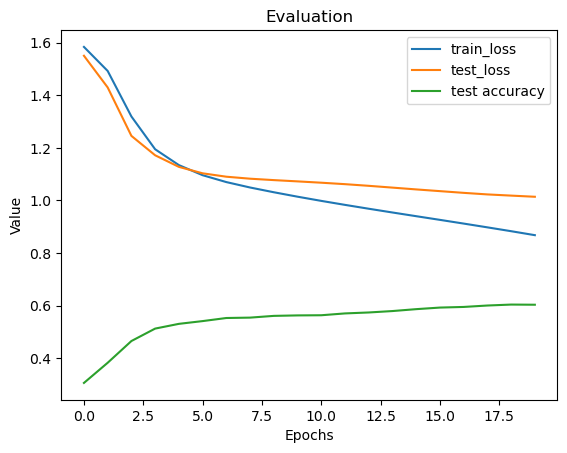

In [11]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train_loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test_loss')
plt.plot([i for i in range(epochs)], test_acc_arr, label='test accuracy')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend();

### As you can see, our basic CNN model has done better than a blind coin toss. 
### However, this is not enough for a Deep Learning task.
### Let's see how well a pre-trained model can do.

## ResNet50

In [12]:
weights = torchvision.models.ResNet50_Weights.DEFAULT 
model = torchvision.models.resnet50(weights=weights).to(device)

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, 
                    out_features=NUM_CLASS, # same number of output units as our number of classes
                    bias=True)).to(device)

### We have froze the layers for which we do not want to amend the weights.
### We are going to work with the pre-trained weights and only work on the last remainig classifer layer.

In [15]:
# Setup loss function and optimizer
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

epochs = 20

train_loss_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(data_loaders['train']):
            
        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(data_loaders['train'])
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loaders['val']):
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
            # Calculate accuracy 
            test_acc += accuracy(test_pred, y)[0]
            
        test_loss /= len(data_loaders['val'])
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_acc /= len(data_loaders['val'])
        test_acc_arr.append(test_acc.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")


Epoch: 0 | Train loss: 1.42629 | Test loss: 1.24975, Test acc: 71.33%


Epoch: 1 | Train loss: 1.14981 | Test loss: 1.03051, Test acc: 79.20%


Epoch: 2 | Train loss: 0.98124 | Test loss: 0.89362, Test acc: 81.58%


Epoch: 3 | Train loss: 0.87126 | Test loss: 0.80164, Test acc: 82.84%


Epoch: 4 | Train loss: 0.79426 | Test loss: 0.73565, Test acc: 83.68%


Epoch: 5 | Train loss: 0.73712 | Test loss: 0.68581, Test acc: 84.16%


Epoch: 6 | Train loss: 0.69276 | Test loss: 0.64662, Test acc: 84.76%


Epoch: 7 | Train loss: 0.65711 | Test loss: 0.61485, Test acc: 85.72%


Epoch: 8 | Train loss: 0.62766 | Test loss: 0.58843, Test acc: 86.14%


Epoch: 9 | Train loss: 0.60280 | Test loss: 0.56605, Test acc: 86.32%


Epoch: 10 | Train loss: 0.58144 | Test loss: 0.54676, Test acc: 86.63%


Epoch: 11 | Train loss: 0.56283 | Test loss: 0.52992, Test acc: 86.75%


Epoch: 12 | Train loss: 0.54641 | Test loss: 0.51505, Test acc: 87.17%


Epoch: 13 | Train loss: 0.53178 | Test loss: 0.50179, Test a

### Well, that looks better! Way better!
### Let's see how well our model performed.

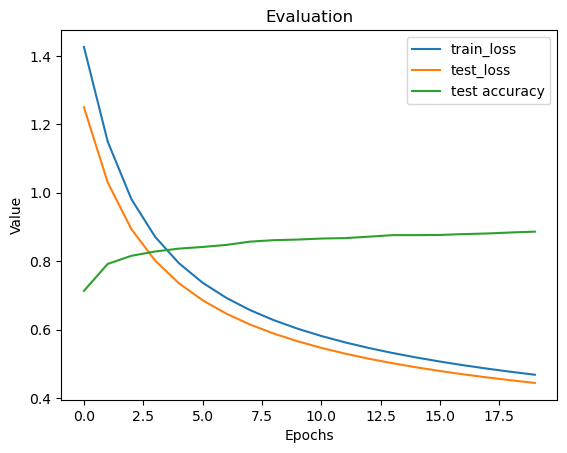

In [16]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train_loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test_loss')
plt.plot([i for i in range(epochs)], test_acc_arr, label='test accuracy')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend();

### Absolutely stunning!
### A graph any machine learning enthusiast would love to see.
### I bet with a longer epoch to train, we would able to obtain better results.

# Evaluation

### Now, let's see how our two models compare when it comes to predicting the test dataset.

In [18]:
# basic_model and model comparison
test_acc = 0
basic_test_acc = []
advanced_test_acc = []

basic_model.eval() 
with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loaders['test']):
        
        X = X.to(device)
        y = y.to(device)
            
        # Forward
        test_pred = basic_model(X)
        
        # Calculate accuracy 
        test_acc += accuracy(test_pred, y)[0]
            
    test_acc /= len(data_loaders['test'])
    basic_test_acc.append(test_acc.cpu().detach().numpy())
    
test_acc = 0
model.eval() 
with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loaders['test']):
        
        X = X.to(device)
        y = y.to(device)
            
        # Forward
        test_pred = model(X)
            
        # Calculate accuracy 
        test_acc += accuracy(test_pred, y)[0]

    test_acc /= len(data_loaders['test'])
    advanced_test_acc.append(test_acc.cpu().detach().numpy())
    
print(f"The accuracy for basic model is {basic_test_acc[0]*100:.2f} and the accuracy for the advanced model is {advanced_test_acc[0]*100:.2f}")

The accuracy for basic model is 63.54 and the accuracy for the advanced model is 89.93


### As we can see, the power of transfer learning by using pre-trained models is definitely noticeable.
### So next time you come across a deep learning task, think about utilizing one of those amazing pre-trained models!